In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# Problem 1

In [26]:
# Generating a Poisson background with mean of 100.
background = stats.poisson.rvs(100,size=1000000)

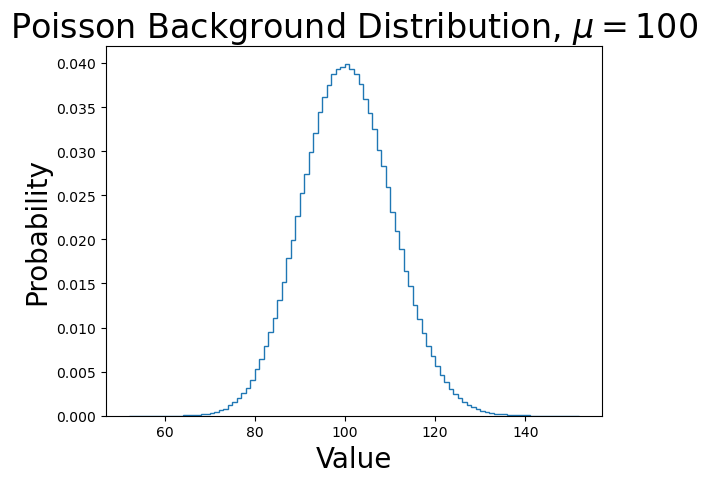

In [32]:
# plotting the background
plt.title("Poisson Background Distribution, $\mu=100$",fontsize=24)
plt.xlabel('Value',fontsize=20)
plt.ylabel('Probability',fontsize=20)

plt.hist(background, histtype='step',density=True,bins=100)

plt.show()

In the above graph, we see the generated background distribution of a Poisson with a mean of 100. This graph looks remarkably like a normal distribution, and this is due to the fact that a Poisson with a high mean begins to approximate a Gaussian.

In [42]:
# Finds probability of 5 sigma event
prob = stats.norm.cdf(5)

# Finds the inverse of the probility, i.e. the number of events needed for a 5 sigma reading
events = stats.poisson.ppf(prob, mu=100)
print("The 5 sigma threshold for a Poisson Distribution (mu = 100) is {} events.".format(events))

The 5 sigma threshold for a Poisson Distribution (mu = 100) is 154.0 events.


The above code first looks at a 0 centered Gaussian with a standard deviation of 1. It finds the area under the curve between 5 and infinity, or in other words the odds that a measurement would be 5 or higher. This probability is then passed into the percent point function of a Poisson with a mean of 100. The percent point function finds the point along the distribution with the given mean where the integral from that point to infinity is equal to the number passed in. So ```events = stats.poisson.ppf(prob, mu=100)``` is solving for $a$ in the equation $\int_{events}^{a} \frac{100^x}{x!}e^{-100}dx = \int_{5}^{\infty}\frac{1}{2\pi}e^{-\frac{1}{2}x^2}dx$. In this equation, a is 154.